#  Homework 2

Deadline: March 10th 11:59pm

Hand in: the homework must be handed in through the Moodle system. 

<span style="color:red">Provide a written answer if requested in the exercise! These questions are marked in red.</span>

---

## Exercise 1 

APIs are a great way to collect data for your projects. Here are a few API you can try out:

- https://developer.nytimes.com/docs/archive-product/1/overview
- https://api.wikimedia.org/wiki/Getting_started_with_Wikimedia_APIs
- https://api.semanticscholar.org/api-docs/graph#tag/Paper-Data/operation/get_graph_get_paper_citations

In this exercise you'll collect and clean data from an API. This could be a good oportunity to collect data for your final project. (20%)

**a)** Collect data from an API of your choice. Proccess the returned data so that each unique data feature is a column in a pandas dataframe. Investigate missing data, such as NaN values, and apply a solution. Cast data columns to be the right type for the data they contain. Display the cleaned data frame using .head().

In [1]:
import requests
import json

In [2]:
api_key = 'lt06iVOvngWYAy29i79LsYG8fa99LrVn' 
url = 'https://api.nytimes.com/svc/archive/v1/2019/1.json?api-key=' + api_key

In [3]:
response = requests.get(url).json()['response']['docs']

In [4]:
with open("./Data/nytimes.json", "w") as file:
    json.dump(response, file, indent=4)


Now we can load the data to the dataframe

In [5]:
import pandas as pd

df2 = pd.DataFrame(response)

/tmp/ipykernel_97116/2705903173.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


We notice that print_section and print_page columns have missing data

In [6]:
print(len(df2))
print(len(df2['print_page'].dropna()))
print(len(df2['print_section'].dropna()))


4482
3127
3127


Filter by important columns (and columns that don't have missing data)

In [7]:
keys = ["id", "abstract", "section_name", "headline", "pub_date", "document_type", "word_count"]

In [8]:
df = pd.DataFrame(columns = keys)

In [9]:
from datetime import datetime

In [10]:
for id, article in enumerate(response):
    df_row = { 
        "id": id,
        "abstract": article["abstract"], 
        "section_name": article["section_name"], 
        "headline": article["headline"]["print_headline"], 
        "pub_date": datetime.strptime(article["pub_date"], "%Y-%m-%dT%H:%M:%S%z"), 
        "document_type": article["document_type"], 
        "word_count": int(article["word_count"])
    }
    df = pd.concat([df, pd.DataFrame(df_row, index=[0])])

/tmp/ipykernel_97116/2592702127.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(df_row, index=[0])])


In [11]:
print(df.head())

  id                                           abstract section_name  \
0  0  From the Treaty of Versailles to Prohibition, ...      Opinion   
0  1  Imagine what we could do with our money, and h...      Opinion   
0  2  Wells was a deep threat for the vaunted Oaklan...   Obituaries   
0  3      Can the Constitution withstand the partisans?      Opinion   
0  4  The Christian right doesn’t like the president...      Opinion   

                                            headline  \
0                                                      
0                      In Search of Lost Screen Time   
0  Warren Wells, 76, Receiver  Derailed by Legal ...   
0                     2019:  The Year  Of the Wolves   
0                     Why Trump Reigns as King Cyrus   

                   pub_date document_type word_count  
0 2019-01-01 00:00:03+00:00       article       2248  
0 2019-01-01 00:00:07+00:00       article        985  
0 2019-01-01 00:08:04+00:00       article        701  
0 2019-01-

**b)** Use the dataframe created in part a) to answer an exploratory data analysis question of your choice. State your question, design a data visualization that answers your question and <span style="color:red">discuss</span>.

Plot how many articles were published for each section weekly. Filter by top 10 topics for each week

<Axes: title={'center': 'Number of articles published per week'}, xlabel='Calendar Week in 2019', ylabel='Number of articles'>

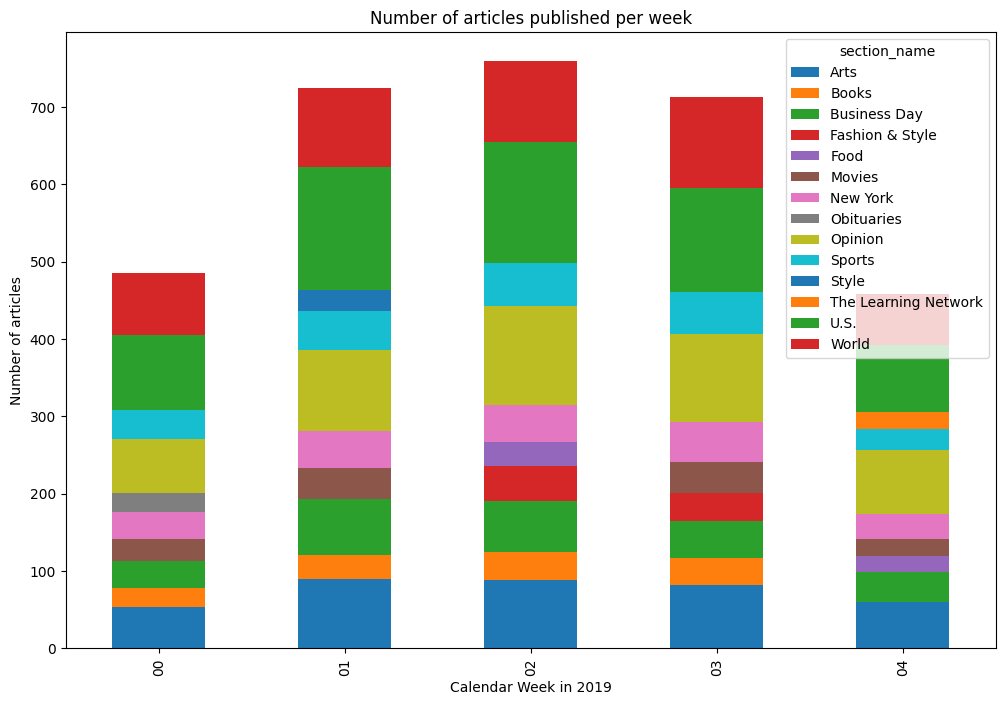

In [37]:
df.groupby([df['pub_date'].dt.strftime('%W'),'section_name']).size().unstack().apply(lambda x: x.nlargest(10), axis=1).plot(
    kind='bar',
    stacked=True, 
    title='Number of articles published per week',
    xlabel='Calendar Week in 2019',
    ylabel='Number of articles',
    figsize=(12,8)
)

## Exercise 2 

The [Round University Ranking (RUR)](https://roundranking.com/ranking/world-university-rankings.html#world-2021) evaluates the performance of 867 world’s leading higher education institutions by 20 indicators grouped into 4 key areas of university activity: Teaching, Research, International Diversity, Financial Sustainability. The top 100 universities are placed in the diamond league, the next 100 in the gold league and so on... (40%)

**a)**  Using the scraping techniques covered in class, scrape the following data fields about the universities (from the website linked above): The name of the University, in which country the University is located, their score and league given by the RUR ranking. Then load the data into a Pandas DataFrame called *df* with the following column names: <font style='font-style : oblique'>University</font>, <font style='font-style : oblique'>Country</font>, <font style='font-style : oblique'>Score</font> and <font style='font-style : oblique'>League</font>. 

IMPORTANT: You should not re-scrape the data every time you work on the homework, because we don't want the RUR servers to get overloaded. Instead, scrape the data once and then save it to a local file on your computer (Hint: use the *pd.to_csv()* function), then load the data from this file instead of re-scraping the website.

In [ ]:
!pip install beautifulsoup4
!pip3 install selenium
!pip3 install webdriver-manager

In [ ]:
import bs4
import selenium

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
driver.get('https://roundranking.com/ranking/world-university-rankings.html#world-2021')

In [ ]:
soup = bs4.BeautifulSoup(driver.page_source, 'html.parser')
table = soup.find_all('table')

Make sure we don't have to rescrape the website by saving the table as an html file

In [ ]:
with open('./Data/soup.html', 'w') as file:
    file.write(table[0].prettify())

Save the table into a dataframe and clean up

In [ ]:
table = soup.find('table')
table_rows = table.find_all('tr')
data = []

for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    data.append(row)


In [ ]:
df = pd.DataFrame(data, columns=['Rank', 'University', 'Score', 'Country', 'Flag', 'League', 'Continent'])
print(df)

In [ ]:
import pandas as pd
with open('./Data/university_rankings.csv', 'w') as file:
    df.to_csv('./Data/table_rows.csv', index=False)


**b)** Filter the data as follows:
- Filter out the US universities. (The analysis aims to find out which universities rank high outside the USA to help US students in choosing a study abroad program.)
- Only keep the universities in the Diamond, Gold, Silver and Bronze league.
- Sort the dataframe by score. <span style="color:red">Which are the top 5 ranking universities?</span>

**c)** Create a word cloud from the Mission Statements of the top Universities. We have already scraped these statements for you. You can find the scraped data [here](https://math.bme.hu/~pinterj/BevAdat1/Adatok/wordcloud.txt)! <br>
- Load the text data from this site into a string variable! (Hint: You can load the data with *urlopen* as shown in Notebook2)
- Omit the word university from the data!
- Create a word cloud, then <span style="color:red">describe what you see in 2-3 sentences!</span>

(Hint: You can find more information on how to create a Word Cloud at https://www.datacamp.com/community/tutorials/wordcloud-python)

---

## Exercise 3 

Let's improve on the model used in class: decision tree on the bank dataset. (40%) 

**a)** In class we solved a classification problem on the *bank.csv* dataset using the kNN algorithm. The classifier performed poorly. Repeat the analysis carried out in class (based on the Notebook02), but now use a decision tree, set the maximum depth to be 6! **Hint:** Use the *tree.DecisionTreeClassifier* classifier!


**b)** Now fit the tree using different parameters! Plot the ROC curve of the decision tree obtained in part a) and the new tree in the same figure (with different colors). Also plot the *y=x* diagonal line!

**c)** Plot and interpret the decision tree. The easiest way to do this is with the sklearn.tree.plot_tree function. Here's a useful article: https://pythoninoffice.com/how-to-a-plot-decision-tree-in-python/.

* If you would like, you can try plotting the decision tree using the graphviz package too. **Hints:** Visualize the decision tree trained in part a) using the *tree.export_graphviz* function. To present the tree use the *graphviz.Source* function or the *SVG* function of the *Ipython.display* package! If *graphviz* is not installed you can install it using the Anaconda Navigator or by using *pip install* or by installing with homebrew, *brew install graphviz*. If it doesn't seem to work you can also download it from this [link](https://graphviz.gitlab.io/download/) and inserting the following lines of codes (use the correct path for your downloaded file):<br><br>
import os <br>
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin') <br><br>

* <span style="color:red">Briefly interpret the results! According to what attribute did we split the tree first? Which were the usual splitting attributes? </span>

**d)** Plot the feature importances for the decision tree. The link in part c) also has useful information about this. <span style="color:red"> Briefly interpret. </span>

## Works Cited:

Please cite all external resources you used to complete this assignment. If you used ChatGPT, please include a link to the conversation.

(https://stackoverflow.com/questions/45281297/group-by-week-in-pandas)[df]

1.a [adding new rows to df](https://stackoverflow.com/questions/75956209/error-dataframe-object-has-no-attribute-append)

1.b [grouping dates by week](https://stackoverflow.com/questions/45281297/group-by-week-in-pandas)